## 19.1 Seatbelts

In [2]:
import matplotlib.pyplot as plt
import arviz as az
from pystan import StanModel
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
df = pd.read_csv("../all_data/glm_seatbelts.csv")
df

,Unnamed: 0,date,deaths,petrol,month
0,1,1969.000000,2.029384,0.102972,1
1,2,1969.083333,1.986772,0.102363,2
2,3,1969.166667,2.008600,0.102062,3
3,4,1969.250000,1.939519,0.100873,4
4,5,1969.333333,2.075547,0.101020,5
...,...,...,...,...,...
187,188,1984.583333,1.982271,0.114797,8
188,189,1984.666667,2.086360,0.114093,9
189,190,1984.750000,2.079181,0.116466,10
190,191,1984.833333,2.136721,0.116026,11


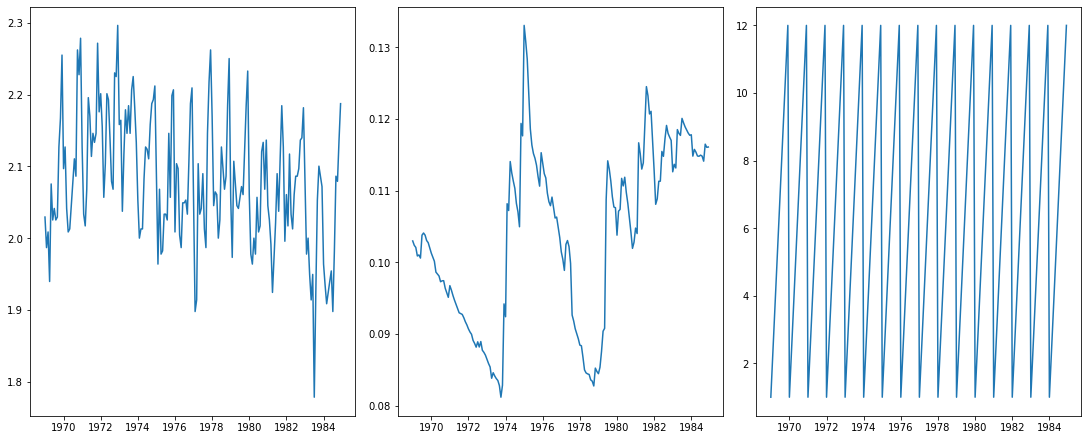

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6), constrained_layout=True)
axs[0].plot(df["date"],df["deaths"])
axs[1].plot(df["date"],df["petrol"])
axs[2].plot(df["date"],df["month"])

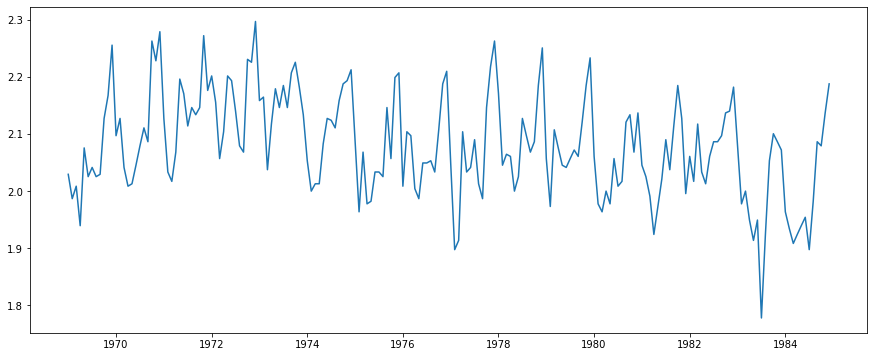

In [11]:
plt.figure(figsize=(15,6))
plt.plot(df["date"],df["deaths"])

In [16]:
model_code = """
    functions{
        // function that returns a dummy variable from 1-11 if in that month.
        // For december return zero to avoid falling into the dummy variable trap
        
        real dummySelector(int aMonth, real[] dummies){
            real aDummy;
            if(aMonth < 12){
                return(dummies[aMonth]);
            }else{
                return(0.0);
            }
        }
    }
    data{
        int N;
        real deaths[N];
        real petrol[N];
        int month[N];
    }
    transformed data{
        real log_unif;
        log_unif = - log(N);
    }
    parameters{
        real beta;
        real delta[11];
        real alpha;
        real<upper=0> gamma;
        real<lower=0> sigma;
    }
    transformed parameters{
        vector[N] lp;
        // discrete uniform prior on s
        lp = rep_vector(log_unif, N);
        for(s in 1:N)
            for(t in 1:N)
                lp[s] = lp[s] + normal_lpdf(deaths[t] | t < s ? (alpha +
                        beta * petrol[t] + dummySelector(month[t], delta)) :
                        (alpha + beta * petrol[t] +
                        dummySelector(month[t], delta) + gamma), sigma);
    }
    model{
        alpha ~ normal(0, 1);
        beta ~ normal(0, 1);
        delta ~ normal(0, 1);
        gamma ~ normal(0, 1);
        sigma ~ normal(0, 1);
        
        // marginalise out s
        target += log_sum_exp(lp);
    }
    generated quantities {
        int<lower=1, upper=N> s;
        s = categorical_rng(softmax(lp));
    }
"""

In [17]:
sm = StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd39e2dc3d61f47697fe26c6532bdb0b NOW.


fit = sm.sampling(
    data=dict(
        N=len(df["deaths"]),
        deaths=df["deaths"].values,
        petrol=df["petrol"].values,
        month=df["month"].values,
    ),
    warmup=500,
    iter=3000,
    chains=4,
)

In [15]:
print(fit)

Inference for Stan model: anon_model_7fe96fc8234c939c203461232b8bacd5.
4 chains, each with iter=3000; warmup=500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

            mean se_mean     sd   2.5%    25%    50%     75%   97.5%  n_eff   Rhat
beta       -1.88  8.3e-3   0.36  -2.57  -2.13  -1.89   -1.65   -1.17   1881    1.0
delta[1]   -0.12  4.3e-4   0.02  -0.16  -0.13  -0.12   -0.11   -0.08   2228    1.0
delta[2]   -0.17  4.3e-4   0.02  -0.21  -0.19  -0.17   -0.16   -0.13   2342    1.0
delta[3]   -0.17  4.3e-4   0.02  -0.21  -0.18  -0.17   -0.16   -0.13   2288    1.0
delta[4]   -0.17  4.2e-4   0.02  -0.21  -0.19  -0.17   -0.16   -0.13   2318    1.0
delta[5]   -0.16  4.3e-4   0.02   -0.2  -0.17  -0.16   -0.14   -0.12   2350    1.0
delta[6]   -0.13  4.3e-4   0.02  -0.17  -0.15  -0.13   -0.12   -0.09   2227    1.0
delta[7]   -0.13  4.3e-4   0.02  -0.17  -0.15  -0.13   -0.12   -0.09   2253    1.0
delta[8]   -0.13  4.3e-4   0.02  -0.17  -0.15  -0.13   -0.12   -

In [30]:
np.median(fit.extract()["s"])

98.0

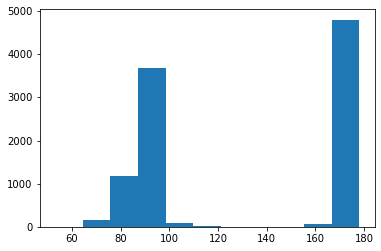

In [28]:
plt.hist(fit.extract()["s"],bins=11);

## 19.2 Model choice for a meta-analysis

In [6]:
df = pd.read_csv("../all_data/glm_metaAnalysis.csv")
df

,Unnamed: 0,x
0,1,6
1,2,4
2,3,9
3,4,7
4,5,3
5,6,2
6,7,10
7,8,5
8,9,7
9,10,3


<AxesSubplot:xlabel='Unnamed: 0', ylabel='x'>

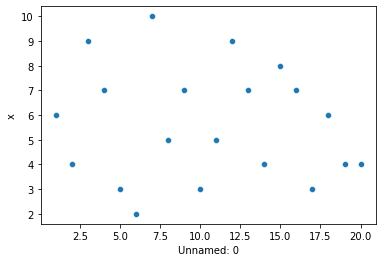

In [7]:
sns.scatterplot(x="Unnamed: 0",y="x",data=df)

In [8]:
df["x"].std()

2.3004576203785834

In [9]:
df["x"].mean()

5.65

In [10]:
model_betabin = """
    data{
        int N;
        int n;
        int X[N];
    }
    parameters{
        real<lower=0> a;
        real<lower=0> b;
    }
    model{
        X ~ beta_binomial(n, a, b);
        a ~ normal(2, 5);
        b ~ normal(2, 5);
    }
    generated quantities{
        vector[N] logLikelihood;
        for(i in 1:N)
            logLikelihood[i] = beta_binomial_lpmf(X[i] | n, a, b);
    }
"""

In [11]:
model_bin = """
    data{
        int N;
        int n;
        int X[N];
    }
    parameters{
        real<lower=0,upper=1> theta;
    }
    model{
        X ~ binomial(n, theta);
        theta ~ beta(1, 1);
    }
    generated quantities{
        vector[N] logLikelihood;
        for(i in 1:N)
            logLikelihood[i] = binomial_lpmf(X[i] | n, theta);
    }
"""

In [12]:
sm_betabin = StanModel(model_code=model_betabin)
sm_bin = StanModel(model_code=model_bin)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_036c33729862ed022c311b50677bfaad NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0faf94c32e8c7fe298ad3bd356f535e0 NOW.


In [13]:
fit_betabin = sm_betabin.sampling(
    data=dict(
        N=len(df["x"]),
        n=10,
        X=df["x"].values,
    ),
    warmup=500,
    iter=3000,
    chains=4,
)

fit_bin = sm_bin.sampling(
    data=dict(
        N=len(df["x"]),
        n=10,
        X=df["x"].values,
    ),
    warmup=500,
    iter=3000,
    chains=4,
)

In [14]:
loo_betabin, _, _ = psisloo(fit_betabin.extract("logLikelihood")["logLikelihood"])
loo_betabin

-45.583228540149676

In [15]:
loo_bin, _, _ = psisloo(fit_bin.extract("logLikelihood")["logLikelihood"])
loo_bin

-49.65769406308476

In [17]:
loo_betabin - loo_bin

4.0744655229350855

In [18]:
model_alternative = """
    data{
        int N;
        int n;
        int X[N];
    }
    parameters{
        real<lower=0> a;
        real<lower=0> b;
        real<lower=0,upper=1> theta;
    }
    transformed parameters{
        vector[2] lp;
        
        for(s in 1:2){
            if(s==1)
                lp[s] = log(0.5) + binomial_lpmf(X | n, theta);
            else
                lp[s] = log(0.5) + beta_binomial_lpmf(X | n, a, b);
        }
    }    
    model{
    
        target += log_sum_exp(lp);
        
        theta ~ beta(1, 1);
        a ~ normal(2, 5);
        b ~ normal(2, 5);
    }
    generated quantities{
        vector[2] lProbs;
        lProbs = exp(lp - log_sum_exp(lp));
    }
"""

In [19]:
sm_alt = StanModel(model_code=model_alternative)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f855ccbd447c1363d7cb38d5727e2c48 NOW.


In [20]:
fit_alt = sm_alt.sampling(
    data=dict(
        N=len(df["x"]),
        n=10,
        X=df["x"].values,
    ),
    warmup=500,
    iter=3000,
    chains=4,
)

In [21]:
print(fit_alt)

Inference for Stan model: anon_model_f855ccbd447c1363d7cb38d5727e2c48.
4 chains, each with iter=3000; warmup=500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

            mean se_mean     sd     2.5%     25%     50%    75%  97.5%  n_eff   Rhat
a           5.53    0.04    2.3     2.11     3.8    5.16   6.92   10.9   3924    1.0
b           4.25    0.03   1.83     1.59    2.91    3.95   5.28   8.56   4053    1.0
theta       0.51  3.8e-3   0.29     0.03    0.26    0.51   0.75   0.98   5679    1.0
lp[1]     -111.1    1.57  86.26   -360.3  -132.1  -77.31 -55.35 -48.82   3038    1.0
lp[2]     -45.52    0.02   0.84   -47.72  -45.77  -45.28 -44.98 -44.76   2933    1.0
lProbs[1] 6.7e-3  1.1e-3   0.05 1.5e-137 2.8e-38 1.6e-14 5.5e-5   0.04   1802    1.0
lProbs[2]   0.99  1.1e-3   0.05     0.96     1.0     1.0    1.0    1.0   1802    1.0
lp__      -45.05    0.02   1.31   -48.47  -45.63  -44.71 -44.09 -43.53   2987    1.0

Samples were drawn using NUTS at Sat Feb  6 1

The posterior distribution for the Pr(s = 2|X) has a mean of 0.99. In this case we strongly prefer
the beta-binomial model. The two approaches use different criteria to choose. They both tend
towards the same answer, that the beta-binomial model is better.

The hierarchical model is really the same as the beta-binomial case, since the latter is essentially,
Xi ~ B(10; theta_i) where theta_i ~ beta(a; b). This is the same as the hierarchical model.

## 19.3 Terrorism

In [4]:
def psisloo(log_lik, **kwargs):
    r"""PSIS leave-one-out log predictive densities.
    Computes the log predictive densities given posterior samples of the log
    likelihood terms :math:`p(y_i|\theta^s)` in input parameter `log_lik`.
    Returns a sum of the leave-one-out log predictive densities `loo`,
    individual leave-one-out log predictive density terms `loos` and an estimate
    of Pareto tail indeces `ks`. The estimates are unreliable if tail index
    ``k > 0.7`` (see more in the references listed in the module docstring).
    Additional keyword arguments are passed to the :meth:`psislw()` function
    (see the corresponding documentation).
    Parameters
    ----------
    log_lik : ndarray
        Array of size n x m containing n posterior samples of the log likelihood
        terms :math:`p(y_i|\theta^s)`.
    Returns
    -------
    loo : scalar
        sum of the leave-one-out log predictive densities
    loos : ndarray
        individual leave-one-out log predictive density terms
    ks : ndarray
        estimated Pareto tail indeces
    """
    # ensure overwrite flag in passed arguments
    kwargs['overwrite_lw'] = True
    # log raw weights from log_lik
    lw = -log_lik
    # compute Pareto smoothed log weights given raw log weights
    lw, ks = psislw(lw, **kwargs)
    # compute
    lw += log_lik
    loos = sumlogs(lw, axis=0)
    loo = loos.sum()
    return loo, loos, ks


def psislw(lw, Reff=1.0, overwrite_lw=False):
    """Pareto smoothed importance sampling (PSIS).
    Parameters
    ----------
    lw : ndarray
        Array of size n x m containing m sets of n log weights. It is also
        possible to provide one dimensional array of length n.
    Reff : scalar, optional
        relative MCMC efficiency ``N_eff / N``
    overwrite_lw : bool, optional
        If True, the input array `lw` is smoothed in-place, assuming the array
        is F-contiguous. By default, a new array is allocated.
    Returns
    -------
    lw_out : ndarray
        smoothed log weights
    kss : ndarray
        Pareto tail indices
    """
    if lw.ndim == 2:
        n, m = lw.shape
    elif lw.ndim == 1:
        n = len(lw)
        m = 1
    else:
        raise ValueError("Argument `lw` must be 1 or 2 dimensional.")
    if n <= 1:
        raise ValueError("More than one log-weight needed.")

    if overwrite_lw and lw.flags.f_contiguous:
        # in-place operation
        lw_out = lw
    else:
        # allocate new array for output
        lw_out = np.copy(lw, order='F')

    # allocate output array for kss
    kss = np.empty(m)

    # precalculate constants
    cutoff_ind = - int(np.ceil(min(0.2 * n, 3 * np.sqrt(n / Reff)))) - 1
    cutoffmin = np.log(np.finfo(float).tiny)
    logn = np.log(n)
    k_min = 1/3

    # loop over sets of log weights
    for i, x in enumerate(lw_out.T if lw_out.ndim == 2 else lw_out[None, :]):
        # improve numerical accuracy
        x -= np.max(x)
        # sort the array
        x_sort_ind = np.argsort(x)
        # divide log weights into body and right tail
        xcutoff = max(
            x[x_sort_ind[cutoff_ind]],
            cutoffmin
        )
        expxcutoff = np.exp(xcutoff)
        tailinds, = np.where(x > xcutoff)
        x2 = x[tailinds]
        n2 = len(x2)
        if n2 <= 4:
            # not enough tail samples for gpdfitnew
            k = np.inf
        else:
            # order of tail samples
            x2si = np.argsort(x2)
            # fit generalized Pareto distribution to the right tail samples
            np.exp(x2, out=x2)
            x2 -= expxcutoff
            k, sigma = gpdfitnew(x2, sort=x2si)
        if k >= k_min and not np.isinf(k):
            # no smoothing if short tail or GPD fit failed
            # compute ordered statistic for the fit
            sti = np.arange(0.5, n2)
            sti /= n2
            qq = gpinv(sti, k, sigma)
            qq += expxcutoff
            np.log(qq, out=qq)
            # place the smoothed tail into the output array
            x[tailinds[x2si]] = qq
            # truncate smoothed values to the largest raw weight 0
            x[x > 0] = 0
        # renormalize weights
        x -= sumlogs(x)
        # store tail index k
        kss[i] = k

    # If the provided input array is one dimensional, return kss as scalar.
    if lw_out.ndim == 1:
        kss = kss[0]

    return lw_out, kss


def gpdfitnew(x, sort=True, sort_in_place=False, return_quadrature=False):
    """Estimate the paramaters for the Generalized Pareto Distribution (GPD)
    Returns empirical Bayes estimate for the parameters of the two-parameter
    generalized Parato distribution given the data.
    Parameters
    ----------
    x : ndarray
        One dimensional data array
    sort : bool or ndarray, optional
        If known in advance, one can provide an array of indices that would
        sort the input array `x`. If the input array is already sorted, provide
        False. If True (default behaviour), the array is sorted internally.
    sort_in_place : bool, optional
        If `sort` is True and `sort_in_place` is True, the array is sorted
        in-place (False by default).
    return_quadrature : bool, optional
        If True, quadrature points and weight `ks` and `w` of the marginal posterior distribution of k are also calculated and returned. False by
        default.
    Returns
    -------
    k, sigma : float
        estimated parameter values
    ks, w : ndarray
        Quadrature points and weights of the marginal posterior distribution
        of `k`. Returned only if `return_quadrature` is True.
    Notes
    -----
    This function returns a negative of Zhang and Stephens's k, because it is
    more common parameterisation.
    """
    if x.ndim != 1 or len(x) <= 1:
        raise ValueError("Invalid input array.")

    # check if x should be sorted
    if sort is True:
        if sort_in_place:
            x.sort()
            xsorted = True
        else:
            sort = np.argsort(x)
            xsorted = False
    elif sort is False:
        xsorted = True
    else:
        xsorted = False

    n = len(x)
    PRIOR = 3
    m = 30 + int(np.sqrt(n))

    bs = np.arange(1, m + 1, dtype=float)
    bs -= 0.5
    np.divide(m, bs, out=bs)
    np.sqrt(bs, out=bs)
    np.subtract(1, bs, out=bs)
    if xsorted:
        bs /= PRIOR * x[int(n/4 + 0.5) - 1]
        bs += 1 / x[-1]
    else:
        bs /= PRIOR * x[sort[int(n/4 + 0.5) - 1]]
        bs += 1 / x[sort[-1]]

    ks = np.negative(bs)
    temp = ks[:,None] * x
    np.log1p(temp, out=temp)
    np.mean(temp, axis=1, out=ks)

    L = bs / ks
    np.negative(L, out=L)
    np.log(L, out=L)
    L -= ks
    L -= 1
    L *= n

    temp = L - L[:,None]
    np.exp(temp, out=temp)
    w = np.sum(temp, axis=1)
    np.divide(1, w, out=w)

    # remove negligible weights
    dii = w >= 10 * np.finfo(float).eps
    if not np.all(dii):
        w = w[dii]
        bs = bs[dii]
    # normalise w
    w /= w.sum()

    # posterior mean for b
    b = np.sum(bs * w)
    # Estimate for k, note that we return a negative of Zhang and
    # Stephens's k, because it is more common parameterisation.
    temp = (-b) * x
    np.log1p(temp, out=temp)
    k = np.mean(temp)
    if return_quadrature:
        np.negative(x, out=temp)
        temp = bs[:, None] * temp
        np.log1p(temp, out=temp)
        ks = np.mean(temp, axis=1)
    # estimate for sigma
    sigma = -k / b * n / (n - 0)
    # weakly informative prior for k
    a = 10
    k = k * n / (n+a) + a * 0.5 / (n+a)
    if return_quadrature:
        ks *= n / (n+a)
        ks += a * 0.5 / (n+a)

    if return_quadrature:
        return k, sigma, ks, w
    else:
        return k, sigma


def gpinv(p, k, sigma):
    """Inverse Generalised Pareto distribution function."""
    x = np.empty(p.shape)
    x.fill(np.nan)
    if sigma <= 0:
        return x
    ok = (p > 0) & (p < 1)
    if np.all(ok):
        if np.abs(k) < np.finfo(float).eps:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            np.negative(x, out=x)
        else:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            x *= -k
            np.expm1(x, out=x)
            x /= k
        x *= sigma
    else:
        if np.abs(k) < np.finfo(float).eps:
            # x[ok] = - np.log1p(-p[ok])
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            np.negative(temp, out=temp)
            x[ok] = temp
        else:
            # x[ok] = np.expm1(-k * np.log1p(-p[ok])) / k
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            temp *= -k
            np.expm1(temp, out=temp)
            temp /= k
            x[ok] = temp
        x *= sigma
        x[p == 0] = 0
        if k >= 0:
            x[p == 1] = np.inf
        else:
            x[p == 1] = -sigma / k
    return x


def sumlogs(x, axis=None, out=None):
    """Sum of vector where numbers are represented by their logarithms.
    Calculates ``np.log(np.sum(np.exp(x), axis=axis))`` in such a fashion that
    it works even when elements have large magnitude.
    """
    maxx = x.max(axis=axis, keepdims=True)
    xnorm = x - maxx
    np.exp(xnorm, out=xnorm)
    out = np.sum(xnorm, axis=axis, out=out)
    if isinstance(out, np.ndarray):
        np.log(out, out=out)
    else:
        out = np.log(out)
    out += np.squeeze(maxx)
    return out